# Extension Comparison: Hindsight Experience Replay (HER) and Prioritized Buffer Extension

In this notebook, we compare our extension using a prioritized replay buffer with two different prioritization strategies. We will compare a traditional DQN agent, a multi-goal DQN+HER agent, and two versions of our DQN+HER+Prioritized_Buffer extension implementation for the simple Bit-Flip environment that has been used by the author as a proof-of-concept to show that HER works significantly better than DQN without HER.

The demonstration includes both training and comparision of the four methods: DQN, DQN+HER, DQN+HER+TD_Error_Priority, and DQN+HER+Closeness_To_Goal_Priority.

Extension:
Our extension of the HER method lies in the replay buffer which we make into a prioritized replay buffer where transitions with higher priority are sampled more often than transitions with lower priority. We assign priority to transitions in two methods: Temporal-Difference (td) Error and Closeness to Goal. The Temporal-Difference Error method assigns higher priority to transitions with higher temporal difference and the Closenss to Goal method assigns higher priority to transitions where either the final state of the episode that the transition is in is closer to the true goal (if the goal was not resampled by HER)  or the resampled HER goal from the episode is closer to the true goal.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
sys.path.append('src')

from train_dqn import train_dqn
from train_dqn_her import train_dqn_her
from train_dqn_her_prioritised import train_dqn_her_prioritized
from utils import print_training_progress, evaluate_agent

### Training DQN, DQN+HER, and DQN+HER+PRIORITIZED_REPLAY

Here, we will use `train_dqn`, `train_dqn_her`, and `train_dqn_her_prioritized` that have some helpful functions for training and evaluation. In these functions, the BitFlip environment is built, an agent is instantiated, and a replay buffer is created for the agent. These agents are then trained in the typical DQN-method.

Here, we have divided the training into 30 epochs with each epoch containing 50 episodes. We will train on the BitFlip environment with a length of 10 bits. This helps us to visualise the success rate in every epoch. The target network weights are updated after every 100 iterations. We use the Adam optimiser with 0.001 learning rate.

In [24]:
n_bits = 15
epochs = 30

config = {
    "environment": {
        "n_bits": n_bits,
        "max_steps": 50
    },

    "dqn": {
        "learning_rate": 0.001,
        "gamma": 0.98,
        "epsilon_start": 1.0,
        "epsilon_end": 0.01,
        "epsilon_decay": 0.995,
        "target_update_freq": 100,
        "batch_size": 128,
        "buffer_size": 100000,
        "hidden_sizes": [256, 256]
    },
    
    "dqn_her": {
        "learning_rate": 0.001,
        "gamma": 0.98,
        "epsilon_start": 1.0,
        "epsilon_end": 0.01,
        "epsilon_decay": 0.995,
        "target_update_freq": 100,
        "batch_size": 128,
        "buffer_size": 100000,
        "hidden_sizes": [256, 256],
        "her_strategy": "future",  # Options: future, final, episode
        "her_k": 4  # Number of additional goals to sample per transition
    },

    "training": {
        "num_epochs": epochs,
        "episodes_per_epoch": 50,
        "eval_episodes": 100,
        "save_results": False,
        "verbose": False,
        "save_freq": 20,
        "log_freq": 1
    },
    
    "experiment": {
        "seed": 42,
        "device": "cpu", # Options: cuda, cpu, mps
        "save_dir": "experiments",
        "plot_style": "seaborn"
    }
}

dqn_results = train_dqn(config)

Training DQN on BitFlip-25
Device: cpu
Network parameters: 77583


Final Evaluation...
Final Success Rate: 0.0000
Mean Episode Length: 15.00

Training completed!


In [25]:
dqn_her_results = train_dqn_her(config)

Training DQN-HER on BitFlip-25
Device: cpu
HER Strategy: future
HER k: 4
Network parameters: 77583


Final Evaluation...
Final Success Rate: 0.9800
Mean Episode Length: 7.66

Training completed!


In [26]:
dqn_her_td_error_priority_results, _ = train_dqn_her_prioritized(
    n_bits=n_bits,
    num_epochs=epochs,
    episodes_per_epoch=50,
    eval_episodes = 100,
    learning_rate = 0.001,
    target_update_freq=100,
    her_strategy='future',
    her_k=4,
    priority_strategy='td_error',
    alpha=0.6,
    beta_start=0.4,
    device='cpu',
    epsilon_end=0.2,
    verbose=False,
    save_results=False
)

=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-15
Observation size: 30
Action size: 15
HER Strategy: future (k=4)
Priority Strategy: td_error
Alpha (priority exponent): 0.6
Beta start (IS exponent): 0.4
Device: cpu

Training complete!
Final training success rate: 0.920


In [27]:
dqn_her_closeness_to_goal_priority_results, dqn_her_closeness_to_goal_priority_agent = train_dqn_her_prioritized(
    n_bits=n_bits,
    num_epochs=epochs,
    episodes_per_epoch=50,
    eval_episodes = 100,
    learning_rate = 0.001,
    target_update_freq=100,
    her_strategy='future',
    her_k=4,
    priority_strategy='closeness_to_goal',
    alpha=0.6,
    beta_start=0.4,
    device='cpu',
    epsilon_end=0.2,
    verbose=False,
    save_results=False
)

=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-15
Observation size: 30
Action size: 15
HER Strategy: future (k=4)
Priority Strategy: closeness_to_goal
Alpha (priority exponent): 0.6
Beta start (IS exponent): 0.4
Device: cpu

Training complete!
Final training success rate: 0.940


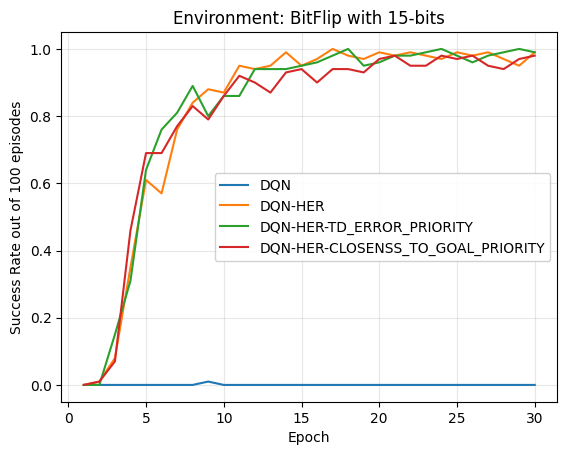

In [30]:
results_to_plot = {
    'DQN': dqn_results,
    'DQN-HER': dqn_her_results,
    'DQN-HER-TD_ERROR_PRIORITY': dqn_her_td_error_priority_results,
    'DQN-HER-CLOSENSS_TO_GOAL_PRIORITY': dqn_her_closeness_to_goal_priority_results
}

plt.figure()

for name, result_data in results_to_plot.items():
    success_rates = result_data['eval_success_rates']
    epochs = np.arange(1, len(success_rates) + 1)
    
    plt.plot(epochs, success_rates, label=name)

plt.xlabel('Epoch')
plt.ylabel('Success Rate out of 100 episodes')
plt.title(f'Environment: BitFlip with {n_bits}-bits')
plt.legend(framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.05])
plt.show()

### Comparing DQN and DQN-HER

Now, with this minimal implementation, we could demonstrate that above a certain number of bits, DQN fails to achieve any consistent success. Whereas DQN with HER achieves almost perfect success rate. This is the result of the reward getting more sparse as the search space becomes larger with only one state having non-negative reward.

In [7]:
bits = [5, 10, 15, 20, 25, 30]

In [8]:
dqn_results_temp = []
for bit_num in bits:
    config['environment']['n_bits'] = bit_num
    results = train_dqn(config)
    dqn_results_temp.append(results['eval_success_rates'][-1])

dqn_results = [bits, dqn_results_temp]

Training DQN on BitFlip-25
Device: cpu
Network parameters: 69893


Final Evaluation...
Final Success Rate: 1.0000
Mean Episode Length: 2.43

Training completed!
Training DQN on BitFlip-25
Device: cpu
Network parameters: 73738


Final Evaluation...
Final Success Rate: 0.0000
Mean Episode Length: 10.00

Training completed!
Training DQN on BitFlip-25
Device: cpu
Network parameters: 77583


Final Evaluation...
Final Success Rate: 0.0000
Mean Episode Length: 15.00

Training completed!
Training DQN on BitFlip-25
Device: cpu
Network parameters: 81428


Final Evaluation...
Final Success Rate: 0.0000
Mean Episode Length: 20.00

Training completed!
Training DQN on BitFlip-25
Device: cpu
Network parameters: 85273


Final Evaluation...
Final Success Rate: 0.0000
Mean Episode Length: 25.00

Training completed!
Training DQN on BitFlip-25
Device: cpu
Network parameters: 89118


Final Evaluation...
Final Success Rate: 0.0000
Mean Episode Length: 30.00

Training completed!


In [9]:
dqn_her_results_temp = []
for bit_num in bits:
    config['environment']['n_bits'] = bit_num
    results = train_dqn_her(config)
    dqn_her_results_temp.append(results['eval_success_rates'][-1])

dqn_her_results = [bits, dqn_her_results_temp]

Training DQN-HER on BitFlip-25
Device: cpu
HER Strategy: future
HER k: 4
Network parameters: 69893


Final Evaluation...
Final Success Rate: 1.0000
Mean Episode Length: 2.40

Training completed!
Training DQN-HER on BitFlip-25
Device: cpu
HER Strategy: future
HER k: 4
Network parameters: 73738


Final Evaluation...
Final Success Rate: 0.9800
Mean Episode Length: 5.01

Training completed!
Training DQN-HER on BitFlip-25
Device: cpu
HER Strategy: future
HER k: 4
Network parameters: 77583


Final Evaluation...
Final Success Rate: 0.9800
Mean Episode Length: 7.66

Training completed!
Training DQN-HER on BitFlip-25
Device: cpu
HER Strategy: future
HER k: 4
Network parameters: 81428


Final Evaluation...
Final Success Rate: 0.8500
Mean Episode Length: 11.51

Training completed!
Training DQN-HER on BitFlip-25
Device: cpu
HER Strategy: future
HER k: 4
Network parameters: 85273


Final Evaluation...
Final Success Rate: 0.7100
Mean Episode Length: 16.22

Training completed!
Training DQN-HER on Bit

In [10]:
dqn_her_td_error_priority_results_temp = []
for bit_num in bits:
    results, _ = train_dqn_her_prioritized(
        n_bits=bit_num,
        num_epochs=30,
        episodes_per_epoch=50,
        eval_episodes = 100,
        learning_rate = 0.001,
        target_update_freq=100,
        her_strategy='future',
        her_k=4,
        priority_strategy='td_error',
        alpha=0.9,
        beta_start=0.4,
        device='cpu',
        epsilon_end=0.2,
        verbose=False,
        save_results=False
    )
    dqn_her_td_error_priority_results_temp.append(results['eval_success_rates'][-1])

dqn_her_td_error_priority_results = [bits, dqn_her_td_error_priority_results_temp]

=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-5
Observation size: 10
Action size: 5
HER Strategy: future (k=4)
Priority Strategy: td_error
Alpha (priority exponent): 0.9
Beta start (IS exponent): 0.4
Device: cpu

Training complete!
Final training success rate: 0.780
=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-10
Observation size: 20
Action size: 10
HER Strategy: future (k=4)
Priority Strategy: td_error
Alpha (priority exponent): 0.9
Beta start (IS exponent): 0.4
Device: cpu

Training complete!
Final training success rate: 0.980
=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-15
Observation size: 30
Action size: 15
HER Strategy: future (k=4)
Priority Strategy: td_error
Alpha (priority exponent): 0.9
Beta start (IS exponent): 0.4
Device: cpu

Training complete!
Final training success rate: 0.860
=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-20
Observation size: 40
Action size: 20
HER Strategy:

In [11]:
dqn_her_closeness_to_goal_priority_results_temp = []
for bit_num in bits:
    results, _ = train_dqn_her_prioritized(
        n_bits=bit_num,
        num_epochs=30,
        episodes_per_epoch=50,
        eval_episodes = 100,
        learning_rate = 0.001,
        target_update_freq=100,
        her_strategy='future',
        her_k=4,
        priority_strategy='closeness_to_goal',
        alpha=0.9,
        beta_start=0.4,
        device='cpu',
        epsilon_end=0.2,
        verbose=False,
        save_results=False
    )
    dqn_her_closeness_to_goal_priority_results_temp.append(results['eval_success_rates'][-1])

dqn_her_closeness_to_goal_priority_results = [bits, dqn_her_closeness_to_goal_priority_results_temp]

=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-5
Observation size: 10
Action size: 5
HER Strategy: future (k=4)
Priority Strategy: closeness_to_goal
Alpha (priority exponent): 0.9
Beta start (IS exponent): 0.4
Device: cpu

Training complete!
Final training success rate: 0.880
=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-10
Observation size: 20
Action size: 10
HER Strategy: future (k=4)
Priority Strategy: closeness_to_goal
Alpha (priority exponent): 0.9
Beta start (IS exponent): 0.4
Device: cpu

Training complete!
Final training success rate: 0.960
=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-15
Observation size: 30
Action size: 15
HER Strategy: future (k=4)
Priority Strategy: closeness_to_goal
Alpha (priority exponent): 0.9
Beta start (IS exponent): 0.4
Device: cpu

Training complete!
Final training success rate: 0.840
=== Training DQN-HER with Prioritized Replay ===
Environment: BitFlip-20
Observation size: 40
Ac

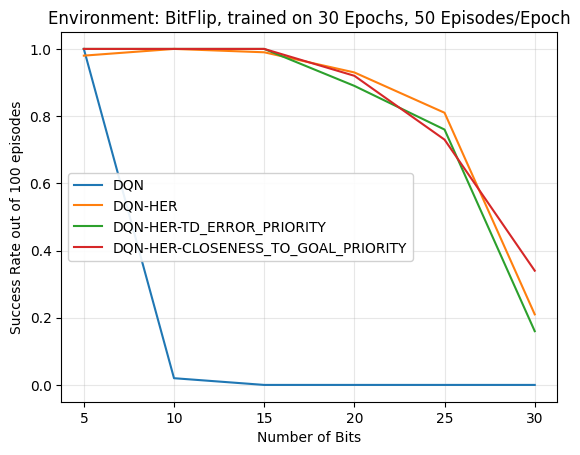

In [13]:
plt.figure()

plt.plot(dqn_results[0], dqn_results[1], label='DQN')
plt.plot(dqn_her_results[0], dqn_her_results[1], label='DQN-HER')
plt.plot(dqn_her_td_error_priority_results[0], dqn_her_td_error_priority_results[1], label='DQN-HER-TD_ERROR_PRIORITY')
plt.plot(dqn_her_closeness_to_goal_priority_results[0], dqn_her_closeness_to_goal_priority_results[1], label='DQN-HER-CLOSENESS_TO_GOAL_PRIORITY')

plt.xlabel('Number of Bits')
plt.ylabel('Success Rate out of 100 episodes')
plt.title('Environment: BitFlip, trained on 30 Epochs, 50 Episodes/Epoch')
plt.legend(framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.05])
plt.show()